In [1]:
import os
os.chdir('../')
os.getcwd()

'c:\\DS projects\\Tesla-Stock-Forecasting'

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from tensorflow.keras.callbacks import Callback,EarlyStopping

df = pd.read_csv('data/TSLA.csv',index_col='Date', parse_dates=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-29,3.800,5.000,3.508,4.778,4.778,93831500
2010-06-30,5.158,6.084,4.660,4.766,4.766,85935500
2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000
2010-07-02,4.600,4.620,3.742,3.840,3.840,25699000
2010-07-06,4.000,4.000,3.166,3.222,3.222,34334500


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2956 entries, 2010-06-29 to 2022-03-24
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2956 non-null   float64
 1   High       2956 non-null   float64
 2   Low        2956 non-null   float64
 3   Close      2956 non-null   float64
 4   Adj Close  2956 non-null   float64
 5   Volume     2956 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 161.7 KB


In [6]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2956.000000,2956.000000,2956.000000,2956.000000,2956.000000,2.956000e+03
mean,138.691296,141.771603,135.425953,138.762183,138.762183,3.131449e+07
std,250.044839,255.863239,243.774157,250.123115,250.123115,2.798383e+07
min,3.228000,3.326000,2.996000,3.160000,3.160000,5.925000e+05
25%,19.627000,20.402000,19.127500,19.615000,19.615000,1.310288e+07
50%,46.656999,47.487001,45.820002,46.545000,46.545000,2.488680e+07
75%,68.057001,69.357500,66.911501,68.103998,68.103998,3.973875e+07
max,1234.410034,1243.489990,1217.000000,1229.910034,1229.910034,3.046940e+08


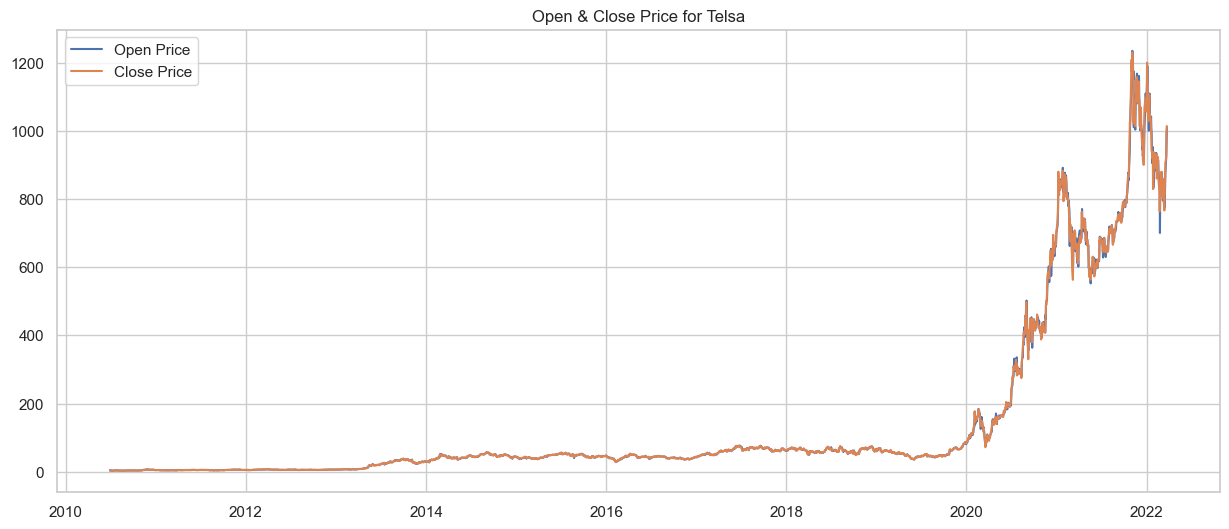

In [12]:
sns.set_theme(style='whitegrid')

plt.figure(figsize=(15,6))
plt.plot(df.index, df['Open'], label='Open Price')
plt.plot(df.index, df['Close'], label='Close Price')
plt.legend()
plt.title('Open & Close Price for Telsa')
plt.show()

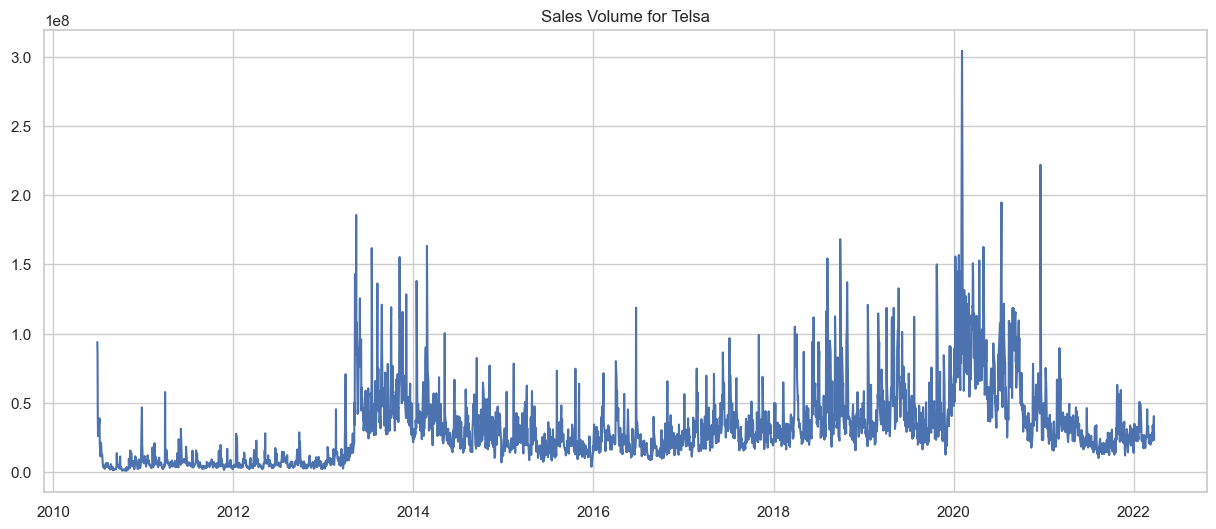

In [14]:
plt.figure(figsize=(15,6))
plt.plot(df.index, df['Volume'])
plt.title('Sales Volume for Telsa')
plt.show()

In [17]:
# Coosing the predicted column
dataset = df['Close']
dataset = pd.DataFrame(dataset)
data = dataset.values
data.shape

(2956, 1)

In [19]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data = scaler.fit_transform(data)
data.shape

(2956, 1)

In [20]:
train_size = int(len(data)*0.80)
train_size

2364

In [24]:
train_data = data[:train_size]
test_data = data[train_size-60:]

In [25]:
train_data.shape, test_data.shape

((2364, 1), (652, 1))

In [26]:
# Creating training and test data
def create_sequence(data, timestamp):
    X, y = [],[]
    for i in range(len(data)-timestamp):
        X.append(data[i:i+timestamp])
        y.append(data[i+timestamp])
    return np.array(X), np.array(y)

In [27]:
X_train, y_train = create_sequence(train_data, 60)
X_test, y_test = create_sequence(test_data, 60)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (2304, 60, 1), y_train shape: (2304, 1)
X_test shape: (592, 60, 1), y_test shape: (592, 1)


### LSTM Model ###

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1],1), activation='tanh', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='tanh', return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(32))
model.add(Dropout(0.2))
model.add(Dense(32))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 32)                1632      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                1

In [30]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), callbacks=[EarlyStopping(patience=10, monitor='val_loss')], epochs=100)

Epoch 1/100
72/72 [==============================] - 3s 36ms/step - loss: 3.6112e-05 - val_loss: 0.0037
Epoch 2/100
72/72 [==============================] - 2s 28ms/step - loss: 3.8674e-05 - val_loss: 0.0075
Epoch 3/100
72/72 [==============================] - 2s 29ms/step - loss: 3.2101e-05 - val_loss: 0.0040
Epoch 4/100
72/72 [==============================] - 2s 27ms/step - loss: 2.9860e-05 - val_loss: 0.0029
Epoch 5/100
72/72 [==============================] - 2s 30ms/step - loss: 3.0865e-05 - val_loss: 0.0023
Epoch 6/100
72/72 [==============================] - 2s 29ms/step - loss: 2.7151e-05 - val_loss: 0.0036
Epoch 7/100
72/72 [==============================] - 2s 29ms/step - loss: 2.5461e-05 - val_loss: 0.0049
Epoch 8/100
72/72 [==============================] - 2s 26ms/step - loss: 2.6178e-05 - val_loss: 0.0032
Epoch 9/100
72/72 [==============================] - 2s 26ms/step - loss: 2.0875e-05 - val_loss: 0.0054
Epoch 10/100
72/72 [==============================] - 2s 26ms/st

19/19 [==============================] - 1s 12ms/step


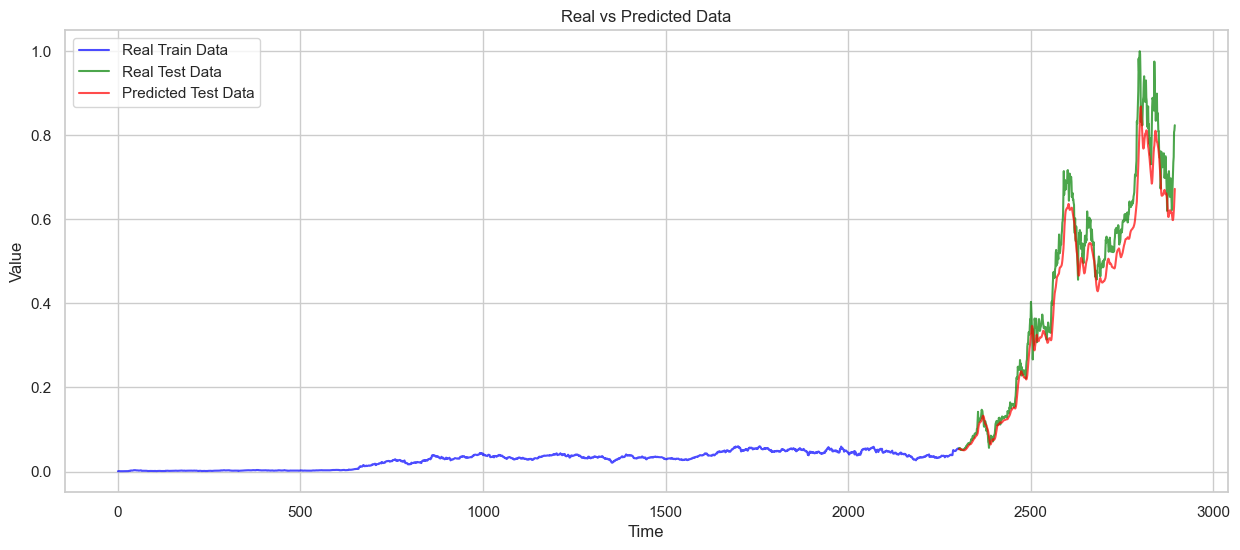

In [31]:
# Predicting on test data
predicted_test_data = model.predict(X_test)  # Use the trained model to predict on test data


# Plotting the real train data, test data, and predicted test data
plt.figure(figsize=(15,6))

# Plot real train data
plt.plot(np.arange(len(y_train)), y_train, label='Real Train Data', color='blue', alpha=0.7)

# Plot test data (real values)
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, label='Real Test Data', color='green', alpha=0.7)

# Plot predicted test data
plt.plot(np.arange(len(y_train), len(y_train) + len(predicted_test_data)), predicted_test_data, label='Predicted Test Data', color='red', alpha=0.7)

# Adding labels and title
plt.title('Real vs Predicted Data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()

# Show the plot
plt.show()